In [1]:
import pickle
from tqdm import tqdm_notebook
from cdt.causality.graph import PC
import networkx as nx

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

Detecting 1 CUDA devices.


In [2]:
def BIC_dag(dag_mat, data):
    """Calculate BIC score from adjacency matrix of DAG
    and data."""
    
    
    MSS_t = 0
    for i in range(dag_mat.shape[1]):
        col = dag_mat[:,i]
        y = data.iloc[:,i]
        X = data.iloc[:,col.astype(bool)]
        reg = LinearRegression()
        pars = X.shape[1]
        
        ## If no parents, predict the mean.
        if pars==0:
            y_pred = np.zeros(len(y))
            y_pred[:] = y.mean()

        else:
            reg.fit(X,y)
            y_pred = reg.predict(X)
        MSS = mean_squared_error(y,y_pred)
        MSS_t += MSS
        
    #q+2 parms for each linear regression
    d = dag_mat.astype(bool).sum() + 2*data.shape[1]
    BIC = -data.shape[0]/2*MSS_t - (d/2)*np.log(data.shape[0])
    return BIC

In [3]:
with open('data/data_fill.pkl','rb') as f:
    data_fill_list = pickle.load(f)

    

In [4]:
## Do alpha search on each and choose that graph
alphas_list = []
DAGs_list = []
for data_fill in tqdm_notebook(data_fill_list):
    
    BICs_list = []
    alphas = np.arange(0.05,.1,.01)
    for alpha in tqdm_notebook(alphas):
        pcalg = PC(alpha = alpha)
        dag = pcalg.create_graph_from_data(data_fill)
        dag_mat =np.array(nx.adjacency_matrix(dag).todense())
        BIC = BIC_dag(dag_mat, data_fill)
        BICs_list.append(BIC)
    alpha_best = alphas[np.argmax(BICs_list)]
    pcalg = PC(alpha = alpha_best)
    dag = pcalg.create_graph_from_data(data_fill)
    dag_mat =np.array(nx.adjacency_matrix(dag).todense())
    alphas_list.append(alpha_best)
    DAGs_list.append(dag_mat)

In [5]:
alphas_list

[0.05,
 0.060000000000000005,
 0.05,
 0.05,
 0.060000000000000005,
 0.060000000000000005,
 0.05,
 0.05,
 0.05,
 0.08000000000000002]

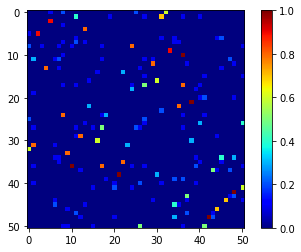

In [6]:
freqs = np.array(DAGs_list).mean(0)
plt.imshow(freqs,cmap='jet')
plt.colorbar()

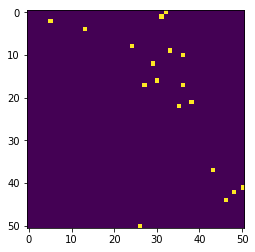

In [7]:
dag_tot = (freqs>=.5).astype(int)
# Arbitrarily choose an orientation
for i in range(dag_tot.shape[0]):
    for j in range(dag_tot.shape[1]):
        if dag_tot[i,j]==1 and dag_tot[j,i]==1:
            dag_tot[j,i] = 0
plt.imshow(dag_tot)

In [8]:
#Check out off diagonal ones
ones = np.argwhere(dag_tot)
for one in ones:
    if one[0] == one[1]:
        continue
    #only get one triangle
    else:
        first = data_fill.columns[one[0]]
        second = data_fill.columns[one[1]]
        print('{}, {}'.format(first,second))

Alabama, New York
Alaska, New Mexico
Arizona, Colorado
California, Illinois
District of Columbia, Mississippi
Florida, North Carolina
Georgia, Oklahoma
Idaho, New Hampshire
Kansas, New Jersey
Kentucky, Nebraska
Kentucky, Oklahoma
Massachusetts, Pennsylvania
Michigan, Ohio
Oregon, Texas
South Dakota, Wyoming
Tennessee, West Virginia
Utah, Virginia
Wyoming, Montana


In [9]:
DAG_PC = pd.DataFrame(dag_tot, index = data_fill_list[0].columns, columns=data_fill_list[0].columns)
DAG_PC.to_csv('data/DAG_PC.csv')